In [1]:
import pandas as pd
import geopandas as gpd
import plotly.express as px
import string
import unicodedata
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings("ignore")

In [10]:
municipality = pd.read_csv("clean_data/turkey_municipality.csv")
parlimentary = pd.read_csv("clean_data/turkish_parlimentary.csv")
parlimentary_d = pd.read_csv("clean_data/milletvekili_detailed.csv")
election_all = pd.read_csv("clean_data/all_data_v_event2.csv")

# Municipality

### Average Turnout for Elections

In [11]:
p_turnout = election_all.groupby("city").percent_turnout.mean().reset_index()
p_turnout = p_turnout[p_turnout.percent_turnout.notna()]
p_turnout = p_turnout.sort_values(by = "percent_turnout", ascending = True)

In [57]:
p_turnout.percent_turnout.mean()

84.06978124398874

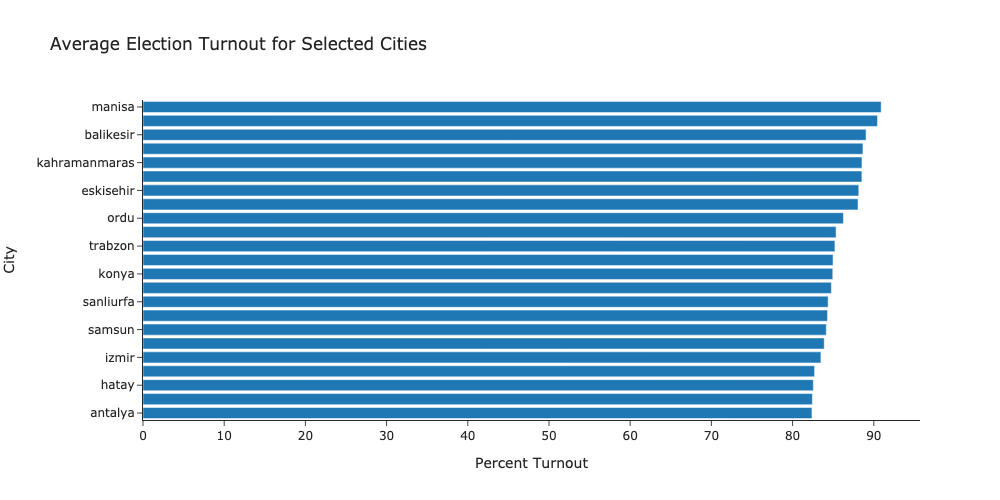

In [12]:
fig = px.bar(p_turnout[10:], x='percent_turnout', y='city', template = "simple_white",
            title="Average Election Turnout for Selected Cities",
            labels={
                     "percent_turnout": "Percent Turnout",
                     "city": "City"
                 })
fig.show(renderer="png", height = 500, width = 1000)
fig.write_image("paper/turnout_selected.png")

In [24]:
time_turnout = election_all.groupby("year").percent_turnout.mean().reset_index()
time_turnout["MA3"] = time_turnout.percent_turnout.rolling(window=3).mean()

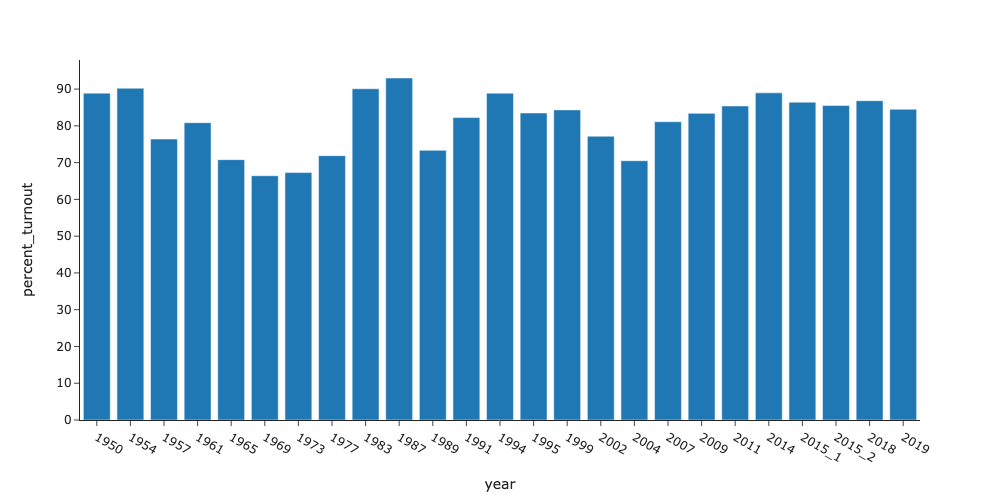

In [27]:
fig = px.bar(time_turnout, x='year', y='percent_turnout', template = "simple_white")
fig.show(renderer="png", height = 500, width = 1000)

## Swings by City

In [43]:
swings = election_all.groupby("city").swing.sum().reset_index()
swings = swings.sort_values(by = "swing", ascending = True)
swings = swings[swings.swing != 0]
swings = swings.sort_values(by = "swing", ascending = False)

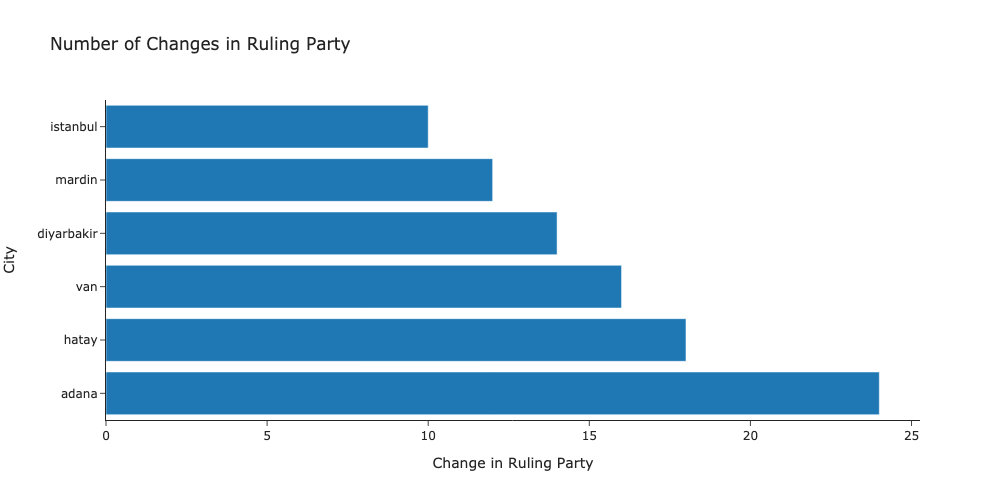

In [51]:
fig = px.bar(swings[:6], x='swing', y='city', template = "simple_white",
            title="Number of Changes in Ruling Party",
        labels={ "swing": "Change in Ruling Party",
                 "city": "City"
                 })
fig.show(renderer="png", height = 500, width = 1000,
         )
fig.write_image("paper/change_party.png")

In [33]:
swings[:5]

,city,swing
9,erzurum,2
10,eskisehir,2
27,samsun,2
17,kayseri,3
11,gaziantep,3


## Number of Alignment over Year

In [53]:
alignment = municipality.groupby(["year"])[["nationalist", "right_wing", "left_wing", "political_islam", "kurdish", "liberal",
                               "socialist", "soc_democ", "populist"]].sum()
alignment["total"] = alignment.sum(axis = 1)
for column in alignment.columns:
    alignment[column] = alignment[column] / alignment["total"]
alignment.drop(columns = ["total"], inplace = True)    
alignment = alignment.reset_index()
alignment = pd.melt(alignment, id_vars="year", value_vars=alignment.columns[1:])

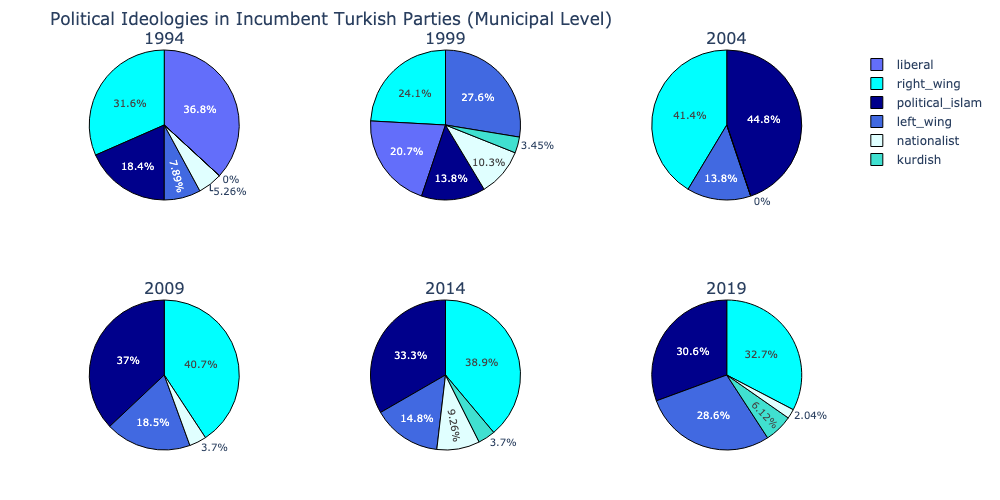

In [55]:
fig = make_subplots(2, 3, specs=[[{'type':'domain'}, {'type':'domain'}, {'type':'domain'}],
                                [{'type':'domain'}, {'type':'domain'}, {'type':'domain'}]],
                   subplot_titles=[str(i) for i in alignment.year.unique()[1:]])
i = 1
j = 1
for year in alignment.year.unique()[1:]:
    fig.add_trace(go.Pie(labels=alignment[alignment.year == year].variable.unique(), 
                         values=alignment[alignment.year == year].value.unique(),
                         name=f"Share of Cities {year}"), i, j)
    j += 1
    if j > 3:  
        j = 1
        i += 1 
    
fig.update_layout(
    margin=dict(l=50, r=50, t=50, b=50),
    paper_bgcolor="white",
    title = "Political Ideologies in Incumbent Turkish Parties (Municipal Level)"
) 
colors = ["lightcyan", "cyan", "royalblue", "darkblue", "turquoise", "ligtblue", "blue"]
fig.update_traces(textfont_size=10,
                  marker=dict(colors=colors, 
                              line=dict(color='#000000', width=1)))
fig.show(renderer="png", height = 500, width = 1000)
fig.write_image("paper/ideologies.png")

In [25]:
swing_dir = municipality[(municipality.swing == 1) & (municipality.nat_prev.notna())]

In [28]:
swing_dir["left_to_right"] = ((swing_dir["left_wing_prev"] == 1) & (swing_dir["right_wing"] == 1)).astype(int)
swing_dir["right_to_left"] = ((swing_dir["right_wing_prev"] == 1) & (swing_dir["left_wing"] == 1)).astype(int)

In [29]:
swing_dir2 = swing_dir.groupby("year")[["left_to_right", "right_to_left"]].sum().reset_index()
swing_dir2["net"] = swing_dir2["left_to_right"] - swing_dir2["right_to_left"]

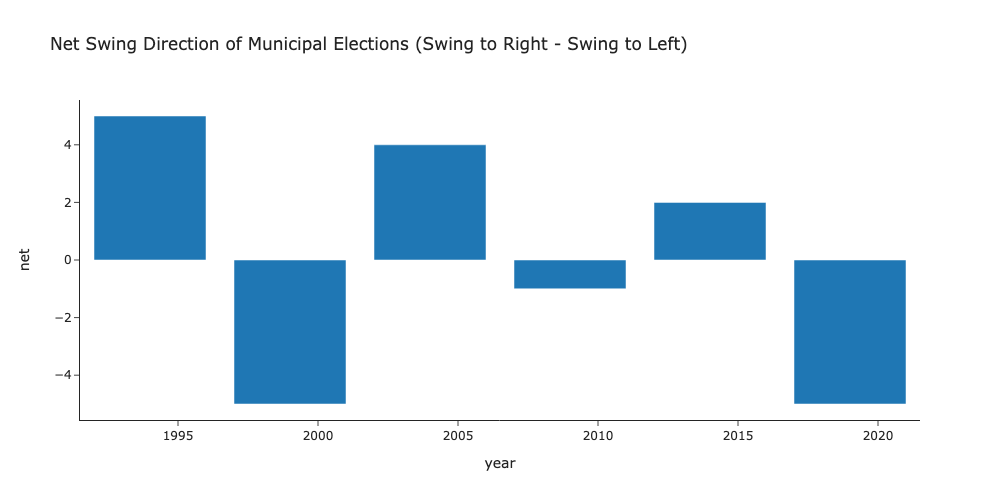

In [31]:
fig = px.bar(swing_dir2, x='year', y='net', template = "simple_white",
            title = "Net Swing Direction of Municipal Elections (Swing to Right - Swing to Left)")
fig.show(renderer="png", height = 500, width = 1000)

In [35]:
swing_dir["perc_turnout"] = swing_dir["turnout"] / swing_dir["registered_voters"]
swing_dir["net"] = swing_dir["left_to_right"] - swing_dir["right_to_left"]

In [36]:
turnout_swing = swing_dir.groupby("net").perc_turnout.mean().reset_index()

In [37]:
turnout_swing.net = turnout_swing.net.astype(str)
turnout_swing.net = turnout_swing.net.str.replace("-1", "Right to Left")
turnout_swing.net = turnout_swing.net.str.replace("0", "No Change")
turnout_swing.net = turnout_swing.net.str.replace("1", "Left to Right")

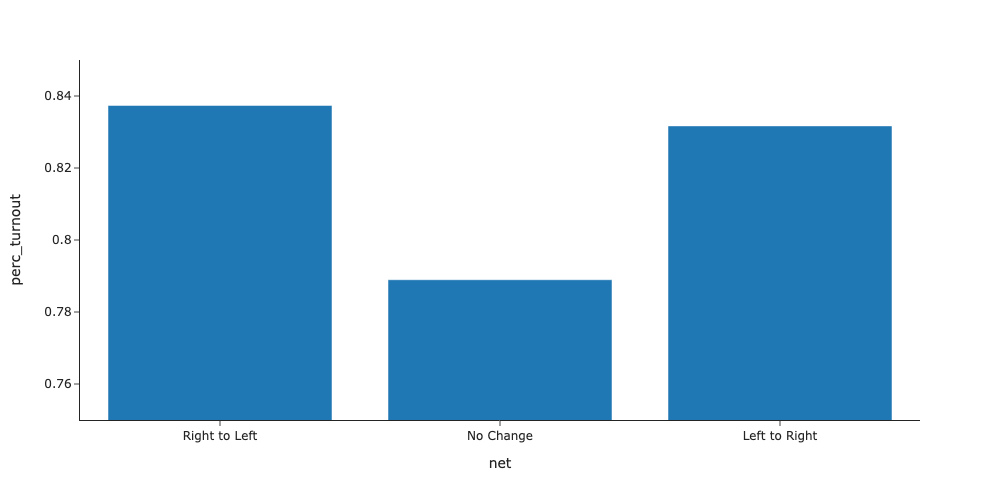

In [38]:
fig = px.bar(turnout_swing, x='net', y='perc_turnout', template = "simple_white")
fig.update_yaxes(range=[0.75, 0.85])
fig.show(renderer="png", height = 500, width = 1000)

# All Elections

In [45]:
elections_all = pd.read_csv("clean_data/elections_all.csv")

In [70]:
swing_dir = elections_all[(elections_all.swing == 1) & (elections_all.nat_prev.notna())]

In [71]:
swing_dir["left_to_right"] = ((swing_dir["left_wing_prev"] == 1) & (swing_dir["right_wing"] == 1)).astype(int)
swing_dir["right_to_left"] = ((swing_dir["right_wing_prev"] == 1) & (swing_dir["left_wing"] == 1)).astype(int)

In [72]:
swing_dir2 = swing_dir.groupby("year")[["left_to_right", "right_to_left"]].sum().reset_index()
swing_dir2["net"] = swing_dir2["left_to_right"] - swing_dir2["right_to_left"]

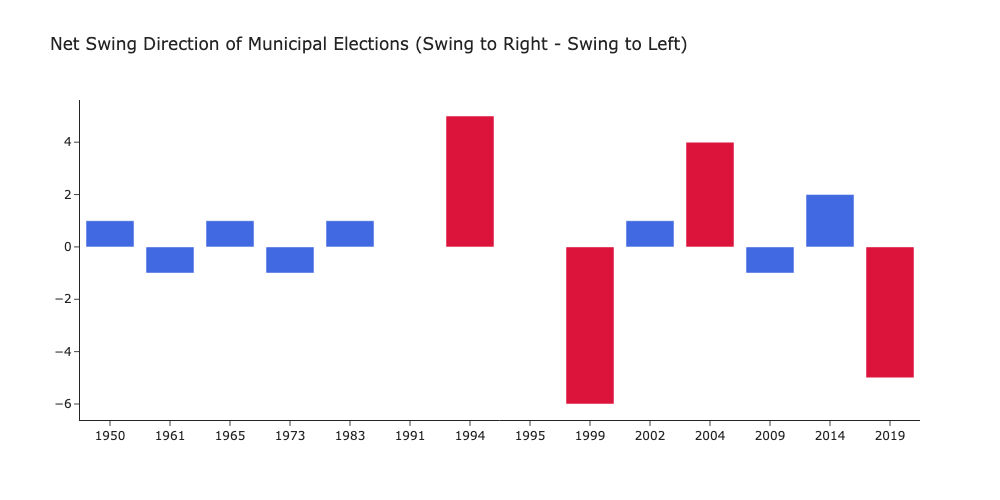

In [91]:
colors = ["royalblue"]*len(swing_dir2.year)
colors[-8] = "crimson"
colors[-6] = "crimson"
colors[-4] = "crimson"
colors[-1] = "crimson"
fig = go.Figure(data=[go.Bar(
    x=swing_dir2.year,
    y=swing_dir2.net,
    marker_color=colors # marker color can be a single color value or an iterable
)])
fig.update_layout(title_text="Net Swing Direction of Municipal Elections (Swing to Right - Swing to Left)",
                 template = "simple_white")
fig.show(renderer="png", height = 500, width = 1000)


In [92]:
swing_dir["perc_turnout"] = swing_dir["turnout"] / swing_dir["registered_voters"]
swing_dir["net"] = swing_dir["left_to_right"] - swing_dir["right_to_left"]

In [93]:
turnout_swing = swing_dir.groupby("net").perc_turnout.mean().reset_index()

In [94]:
turnout_swing.net = turnout_swing.net.astype(str)
turnout_swing.net = turnout_swing.net.str.replace("-1", "Right to Left")
turnout_swing.net = turnout_swing.net.str.replace("0", "No Change")
turnout_swing.net = turnout_swing.net.str.replace("1", "Left to Right")

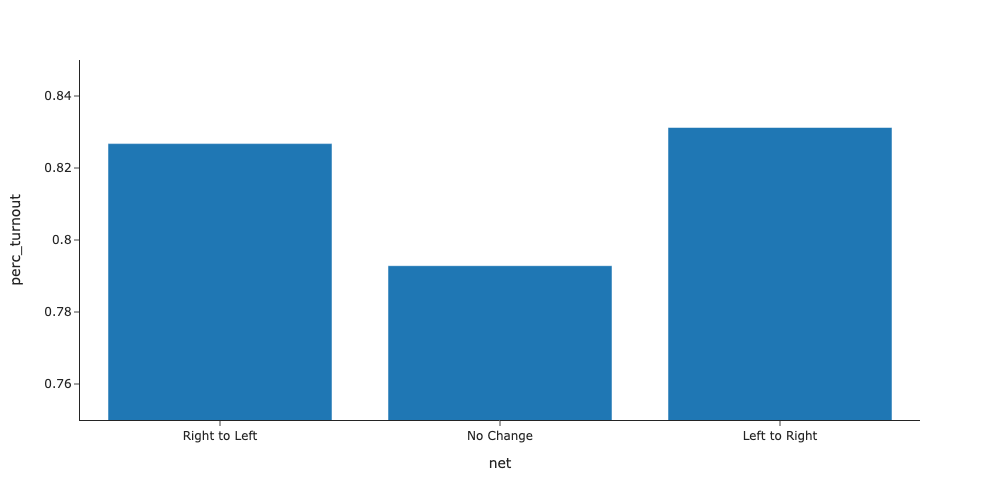

In [95]:
fig = px.bar(turnout_swing, x='net', y='perc_turnout', template = "simple_white")
fig.update_yaxes(range=[0.75, 0.85])
fig.show(renderer="png", height = 500, width = 1000)

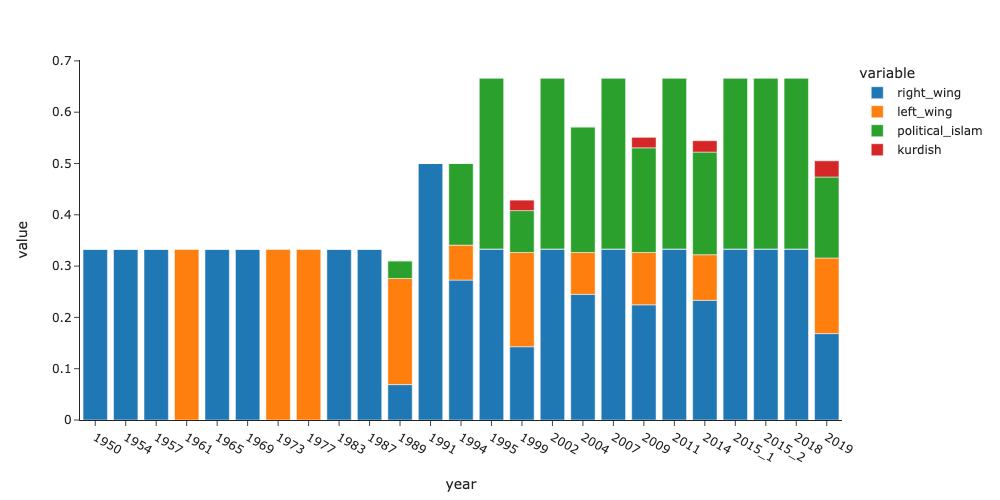

In [123]:
fig = px.bar(alignment[alignment.variable.isin(["left_wing", "right_wing", "political_islam", "kurdish"])], 
              x='year', y='value', color = "variable", template = "simple_white")
fig.show(renderer = "png", height = 500, width = 1000)